# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведем исследовательский анализ данных и установим параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откроем файл с данными и изучим общую информацию

Загрузим данные из csv-файла в датафрейм c помощью библиотеки pandas.


In [1]:
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
display(HTML("<style>.container { width:80% !important; }</style>"))
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
df.sample(6)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
7705,1,2850000.0,36.56,2017-06-22T00:00:00,1,NaN,5.0,15.0,3,NaN,False,False,9.16,0.0,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,104.0
5502,8,2950000.0,44.00,2019-02-04T00:00:00,2,NaN,5.0,27.6,4,NaN,False,False,6.00,1.0,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2576,10,2950000.0,39.70,2018-02-19T00:00:00,2,2.5,4.0,26.0,2,NaN,False,False,6.00,NaN,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,219.0
10612,8,580000.0,31.00,2016-11-16T00:00:00,1,NaN,4.0,19.0,4,NaN,False,False,6.00,NaN,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,387.0
7460,18,8000000.0,40.00,2018-07-22T00:00:00,1,NaN,7.0,10.0,6,NaN,False,False,20.00,NaN,Санкт-Петербург,54723.0,19216.0,1.0,434.0,1.0,429.0,60.0
10547,13,4590000.0,36.00,2015-06-14T00:00:00,1,NaN,25.0,NaN,25,NaN,False,False,NaN,1.0,Санкт-Петербург,9354.0,13149.0,1.0,541.0,1.0,333.0,845.0


Изучим общую информацию о полученном датафрейме.

#### Описание представленных данных
* airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
* balcony — число балконов
* ceiling_height — высота потолков (м)
* cityCenters_nearest — расстояние до центра города (м)
* days_exposition — сколько дней было размещено объявление (от публикации до снятия)
* first_day_exposition — дата публикации
* floor — этаж
* floors_total — всего этажей в доме
* is_apartment — апартаменты (булев тип)
* kitchen_area — площадь кухни в квадратных метрах (м²)
* last_price — цена на момент снятия с публикации
* living_area — жилая площадь в квадратных метрах (м²)
* locality_name — название населённого пункта
* open_plan — свободная планировка (булев тип)
* parks_around3000 — число парков в радиусе 3 км
* parks_nearest — расстояние до ближайшего парка (м)
* ponds_around3000 — число водоёмов в радиусе 3 км
* ponds_nearest — расстояние до ближайшего водоёма (м)
* rooms — число комнат
* studio — квартира-студия (булев тип)
* total_area — общая площадь квартиры в квадратных метрах (м²)
* total_images — число фотографий квартиры в объявлении

Переименуем сразу единственный столбец cityCenters_nearest и приведем к единству наименования 

In [4]:
df = df.rename(columns={'cityCenters_nearest': 'city_centers_nearest'})

#### Первичная частотная оценка данных: гистограммы

Построим гистограмму для всех числовых столбцов таблицы на одном графике.

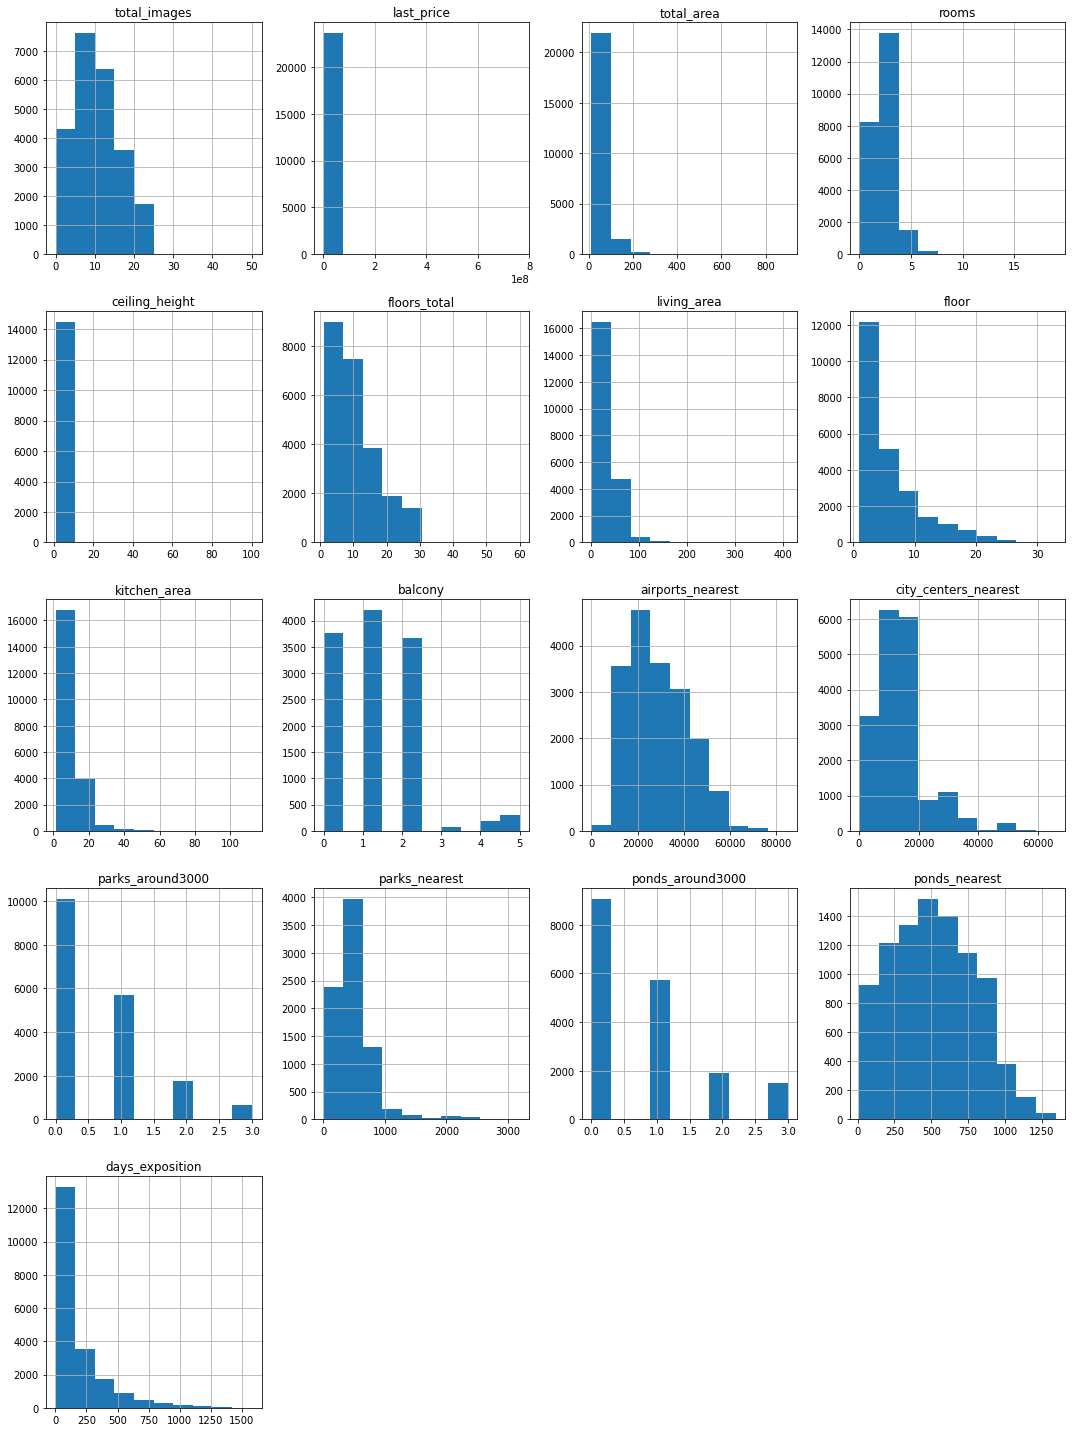

In [5]:
df.hist(figsize=(15,20))
plt.tight_layout() # чтобы не было системного текста сверху и оптимально по размеру подогнались графики

Мы видим, что все представленне данные по большинству признаков имеют распределение сильно смещенное влево: это говорит о том, что данные имеют большие выбросы. При непосредственном анализе данных эти распределения будут нормализованы.

#### Первичная статистическая оценка данных

Посмотрим на первичный статистический анализ данных.

In [6]:
df.describe().round(1)

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.0,23699.0,23699.0,23699.0,14504.0,23613.0,21796.0,23699.0,21421.0,12180.0,18157.0,18180.0,18181.0,8079.0,18181.0,9110.0,20518.0
mean,9.9,6541548.8,60.3,2.1,2.8,10.7,34.5,5.9,10.6,1.2,28793.7,14191.3,0.6,490.8,0.8,518.0,180.9
std,5.7,10887013.3,35.7,1.1,1.3,6.6,22.0,4.9,5.9,1.1,12630.9,8608.4,0.8,342.3,0.9,277.7,219.7
min,0.0,12190.0,12.0,0.0,1.0,1.0,2.0,1.0,1.3,0.0,0.0,181.0,0.0,1.0,0.0,13.0,1.0
25%,6.0,3400000.0,40.0,1.0,2.5,5.0,18.6,2.0,7.0,0.0,18585.0,9238.0,0.0,288.0,0.0,294.0,45.0
50%,9.0,4650000.0,52.0,2.0,2.6,9.0,30.0,4.0,9.1,1.0,26726.0,13098.5,0.0,455.0,1.0,502.0,95.0
75%,14.0,6800000.0,69.9,3.0,2.8,16.0,42.3,8.0,12.0,2.0,37273.0,16293.0,1.0,612.0,1.0,729.0,232.0
max,50.0,763000000.0,900.0,19.0,100.0,60.0,409.7,33.0,112.0,5.0,84869.0,65968.0,3.0,3190.0,3.0,1344.0,1580.0


#### Предварительный итог:  данные на первый взгляд
Всего представлено 23699 объявений о продаже. 
На данных данных гистограммах мы видим, что в большинстве случаев в среднем:
* фото: 8-10 шт;
* цена: менее 1 млрд: ср.арифм = 6.5 млн, медиана = 4.6 млн;
* площадь: Общая площадь до 100 м: ср. арифм = 60.3, медиана = 52; 
* комнат: В среднем продаются двухкомнатные квартиры;
* потолки: Высота потолков указана в 60% случаев и состалвяет в среднем 2 м;
* этажность дома: В среднем это 9-10 этажные дома;
* жилплощадь: 30-34 м;
* этаж: примерно 4-6;
* площадь кухни: 9.1-10.6 м.
* балкон: жилье с 1 балконом в большинстве случаев;
* аэропорт: расположен в 26,7-28,7 км;
* Близость от центра в среднем составляет 13-14 км;
* парк в 3 км: в большинстве случаев нет парков в радиусе 3 км; 
* ближайший парк: если и есть, то в 500 метрах; 
* водоемы: один; 
* ближайший водоем: в 500 метрах;
* средний срок размещения объявления: от 3 месяцев до полугода.


### Предобработка данных

#### Замена пропусков

Найдем и изучим пропущенные значения в столбцах:
определим в процентном соотношении в каких столбцах есть пропуски.

In [7]:
(df.isnull().sum() / len(df) * 100).round(2)

total_images             0.00
last_price               0.00
total_area               0.00
first_day_exposition     0.00
rooms                    0.00
ceiling_height          38.80
floors_total             0.36
living_area              8.03
floor                    0.00
is_apartment            88.29
studio                   0.00
open_plan                0.00
kitchen_area             9.61
balcony                 48.61
locality_name            0.21
airports_nearest        23.38
city_centers_nearest    23.29
parks_around3000        23.28
parks_nearest           65.91
ponds_around3000        23.28
ponds_nearest           61.56
days_exposition         13.42
dtype: float64

<div class="alert alert-warning">
<b>⚠️ Комментарий ревьюера v1:</b> 
<br>Ещё можно посмотреть долю пропущенных значений следующим способом
    
    df.isna().mean()
</div>

Половина полей в датасете имеет пропуски. Наибольшее количество пропусков в указании признака **апартамента**, наличии **парка** или **пруда**, также это балконы, высота потолков и др. (представлено выше). Заполним пропущенные значения там, где это возможно. Например, если продавец **не указал число** балконов, то, **скорее всего**, в его квартире их **нет**. Такие пропуски можно заменить на число 0. Также предалагаем по тому же принципу **заменить на 0** признак **апартамента** (апаратаментов действительно мало на рынке), не указанное расстояние до ближайшего **парка** или **пруда**.


In [8]:
columns_to_fill = ['balcony', 'parks_nearest', 'ponds_nearest', 'is_apartment']
df[columns_to_fill] = df[columns_to_fill].fillna(0)

* **Высота потолков** имеет достаточно больошой процент пропусков 38.8%, вероятно,  следует заменить медианным значением 2.65, так как среднее арифметическое 2.77 это много.

In [9]:
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())

df.isna().mean().round(2)

total_images            0.00
last_price              0.00
total_area              0.00
first_day_exposition    0.00
rooms                   0.00
ceiling_height          0.00
floors_total            0.00
living_area             0.08
floor                   0.00
is_apartment            0.00
studio                  0.00
open_plan               0.00
kitchen_area            0.10
balcony                 0.00
locality_name           0.00
airports_nearest        0.23
city_centers_nearest    0.23
parks_around3000        0.23
parks_nearest           0.00
ponds_around3000        0.23
ponds_nearest           0.00
days_exposition         0.13
dtype: float64

Если логичную замену предложить невозможно, то оставим пропуски. Пропущенные значения — тоже важный сигнал, который нужно учитывать.

#### Замена типов данных

Рассмотрим типы данных в каждом столбце:
Найдем столбцы, в которых нужно изменить тип данных.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

**Замены значений требуют**: 
* **first_day_exposition** - с object на дату: потому что есть специальный функциональный тип даты, которые представляет соответсвующие возможности для работы.
* **is_apartment** - с object на int64: потому что наличие признака апартамента соответсвует булеву типу 1 / 0 (да / нет). с ноль и единицей привычнее работать в аналитике.
* **open_plan** - с bool на int64: раз is_apartment в 1 / 0, то и open_plan в 1 / 0. Логика та же. Можно было и так оставить.
* **days_exposition** - с float64 на int - количество дней не может быть дробным.


In [11]:
df['is_apartment'] = df['is_apartment'].astype(float)
df['days_exposition'] = df['days_exposition'].astype(float)

df['is_apartment'] = df['is_apartment'].round()
df['days_exposition'] = df['days_exposition'].round()
df['last_price'] = df['last_price'].round()
df['floors_total'] = df['floors_total'].round()
df['balcony'] = df['balcony'].round()
df['airports_nearest'] = df['airports_nearest'].round()

dtype_dict = {
    'first_day_exposition': 'datetime64[ns]',
    'is_apartment': 'Int64',
    'days_exposition': 'Int64',
    'last_price': 'Int64',
    'floors_total': 'Int64',
    'balcony': 'Int64',
    'airports_nearest': 'Int64'
}

df = df.astype(dtype_dict)

#### Убираем дубликаты

Изучим уникальные значения в столбце с названиями и устраните неявные дубликаты. Например, «поселок Рябово» и «поселок городского типа Рябово», «поселок Тельмана» и «посёлок Тельмана» — это обозначения одних и тех же населённых пунктов.

In [12]:
# sorted(df.locality_name.unique()) # не удалось отсортировать, потому что типа пытается где-то сравнивать float и str хотя  odject в info написано 
duplicates_count_before = len(df.locality_name.unique())
print(f'Всего уникальных значений {duplicates_count_before}. Потом оценим изменния после обработки дубликатов.')

df.locality_name.unique()

Всего уникальных значений 365. Потом оценим изменния после обработки дубликатов.


array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Сначала создадим отдельный столбец с унифицированным типом населенного пункта, затем его уберем из названия населенного пункта чтобы следоввать правильным принципам хранения данных: с такими данными потом легче и продуктивнее работать и затем перейдем к обработке дубликатов.

In [13]:
replace_dict = {
    'городской посёлок ': 'поселок',
    'посёлок городского типа': 'поселок',
    'поселок городского типа': 'поселок',
    'посёлок городского типа имени': 'поселок',
    'посёлок Пансионат': 'поселок',
    'поселок Пансионат': 'поселок',
    'коттеджный посёлок': 'поселок',
    'поселок станции': 'поселок',
    'посёлок при железнодорожной станции': 'поселок',
    'городского типа': 'поселок',
    
    'посёлок': 'поселок',
    'поселок': 'поселок',
    
    'село': 'село',
    'село': 'село',
    
    'деревня': 'деревня',
    
    'Санкт-Петербург': 'город',
    'Ломоносов': 'город',
    'Сертолово': 'город',
    'Гатчина': 'город',
    'Мурино': 'город',
    'Выборг': 'город',
    'Кронштадт': 'город',
    'Кировск': 'город',
    'Павловск': 'город',
    'Всеволожск': 'город',
    'Волхов': 'город',
    'Кингисепп': 'город',
    'Приозерск': 'город',
    'Сестрорецк': 'город',
    'Сясьстрой': 'город',
    'Ивангород':  'город',
    'Зеленогорск':  'город',
    'Кудрово': 'город',
    'Красное Село': "город",
    'Отрадное': "город",
    'Любань': "город",
    "Светогорск": "город",
    'Пушкин': "город",
    "Шлиссельбург": "город",
    "Петергоф": "город",
    "Коммунар": "город",
    "Колпино": "город",
    "Сосновый Бор": "город",
    "Тихвин": "город",
    "Сланцы": "город",
    "Никольское": "город",
    "Тосно": "город",
    "Кириши": "город",
    "Волосово": "город",
    "Луга": "город",
    "Каменногорск": "город",
    "Лодейное Поле": "город",
    "Бокситогорск": "город",
    "Пикалёво": "город",
    "Подпорожье": "город",
    "Высоцк": "город",
    "Приморск": "город",
    "Новая Ладога": "город",
    
    
    'садовое товарищество': 'садовое товарищество',
    'садоводческое некоммерческое товарищество':  'садовое товарищество',
}

df['type_of_locality'] = df['locality_name'].apply(
    lambda old: next(
        (replace_dict[sub_str_key] for sub_str_key in replace_dict if sub_str_key in str(old)), 
        None))

# проверим все ли заменили
# df.loc[df['type of locality'].isna(), ['type of locality', 'locality_name']] 
# проверили, неучтенных наименований не осталось, остались только ноны

df[['type_of_locality', 'locality_name']].sample(7)

,type_of_locality,locality_name
20072,город,Санкт-Петербург
7371,деревня,деревня Кудрово
3085,город,Колпино
22542,город,Санкт-Петербург
17452,поселок,посёлок Мурино
22780,город,Санкт-Петербург
10199,город,Санкт-Петербург


In [14]:
garbage_part_name = [    
    'городской посёлок ',
    'посёлок городского типа',
    'поселок городского типа',
    'посёлок городского типа имени', 
    'посёлок Пансионат',
    'поселок Пансионат',
    'коттеджный посёлок',
    "коттеджный",
    'поселок станции',
    'посёлок при железнодорожной станции',
    'посёлок',
    'поселок',
    'cело',
    'село',
    'деревня', 
    'садовое товарищество',
    'садоводческое некоммерческое товарищество',
    'городского типа',
    'городской'
    
]

for i in garbage_part_name:
    df['locality_name'] = df['locality_name'].str.replace(i, '')

df['locality_name'] = df['locality_name'].str.strip()
    
print(f'Всего уникальных значений {len(df.locality_name.unique())}. А было {duplicates_count_before} Потом оценим изменния после обработки дубликатов.')
df.locality_name.unique()

Всего уникальных значений 307. А было 365 Потом оценим изменния после обработки дубликатов.


array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодёжное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

Количество уникальных значений сократилось на 20% с 365 до 308 названий населенных пунктов.

In [15]:
df.sample(3)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,type_of_locality
22773,13,2990000,47.8,2017-12-04,2,2.5,5,27.2,2,0,False,False,8.7,1,Сертолово,<NA>,NaN,NaN,0.0,NaN,0.0,72,город
18018,18,9600000,83.0,2017-10-19,3,3.0,9,54.0,6,0,False,False,9.0,0,Санкт-Петербург,16285,6664.0,2.0,295.0,0.0,0.0,<NA>,город
1721,9,1190000,32.5,2019-02-23,1,2.7,5,17.9,2,0,False,False,6.2,0,Елизаветино,<NA>,NaN,NaN,0.0,NaN,0.0,<NA>,поселок


In [16]:
df.duplicated().sum()

0

Дубликатов нет. Названия населенных пунктов нормализованы:
* Типы населенных пунктов вынесены в отдельный столбец type_of_locality и убраны из столбца locality_name

#### Добавим в таблицу новые столбцы

Добавим в таблицу новые столбцы со следующими параметрами:
цена одного квадратного метра (поделим стоимость объекта на его общую площадь, а затем округлим до двух знаков после запятой);
день недели публикации объявления находим логичным и понятнее отобразить 1 - понедельник, 2 - вторник и т.д., несмотря на то, что по заданию было велено 0 — понедельник, 1 — вторник...;
месяц публикации объявления;
год публикации объявления;
тип этажа квартиры (значения — «‎первый», «последний», «другой»);
расстояние до центра города в километрах (перевести из м в км и округлить до ближайших целых значений).

In [17]:
df['last_price'] = df['last_price'].astype(float)
df['total_area'] =  df['total_area'].astype(float)

df['price_1m'] = np.round(df['last_price'] / df['total_area'])
df['publication_day_of_week'] = df['first_day_exposition'].dt.weekday + 1
df['publication_month'] = df['first_day_exposition'].dt.month
df['publication_year'] = df['first_day_exposition'].dt.year

def get_floor_type(row):
    if pd.isna(row['floor']) or pd.isna(row['floors_total']):
        return None
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

df['floor_type'] = df.apply(get_floor_type, axis=1)

df['city_centers_nearest_km'] = np.round(df['city_centers_nearest']/1000,2)
df.sample()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,type_of_locality,price_1m,publication_day_of_week,publication_month,publication_year,floor_type,city_centers_nearest_km
18540,10,6400000.0,65.5,2019-04-10,3,2.65,9,48.0,7,0,False,False,6.3,0,Санкт-Петербург,20129,19131.0,1.0,375.0,2.0,358.0,<NA>,город,97710.0,3,4,2019,другой,19.13


Изучим перечисленные ниже параметры объектов и построим отдельные гистограммы для каждого из этих параметров. В некоторых параметрах встречаются редкие и выбивающиеся значения. При построении гистограмм удалиму их. Например, в столбце ceiling_height может быть указана высота потолков 25 м и 32 м. Логично предположить, что на самом деле это вещественные значения: 2.5 м и 3.2 м. Попробуйте обработать аномалии в этом и других столбцах, если они есть. Если природа аномалии понятна и данные действительно искажены, то восстановите корректное значение. В противном случае удалите редкие и выбивающиеся значения.
Список параметров:
* общая площадь;
* жилая площадь;
* площадь кухни;
* цена объекта;
* количество комнат;
* высота потолков;
* тип этажа квартиры («первый», «последний», «другой»);
* общее количество этажей в доме;
* расстояние до центра города в метрах;
* расстояние до ближайшего парка


In [18]:
columns_list = ['total_area', 'living_area', 'kitchen_area', 'last_price', 'rooms', 'ceiling_height', 'floor_type', 'floors_total', 'city_centers_nearest', 'parks_nearest']

Посмотрим сначала уникальные значения каждого столбца, чтобы определить технические ошибки и попытаться номрализовать данные. например, высоту потолков 25 м в 2,5 м.

In [19]:
for col in columns_list:
    unique_vals = df[col].unique()
    print(f"{col}: {len(unique_vals)} уникальных значений")
    print(f"  {unique_vals}\n")

total_area: 2182 уникальных значений
  [108.    40.4   56.   ...  66.86 133.81  76.75]

living_area: 1783 уникальных значений
  [51.   18.6  34.3  ... 31.65 13.59 42.55]

kitchen_area: 972 уникальных значений
  [ 25.    11.     8.3     nan  41.     9.1   14.4   18.9    8.81   6.5
   8.5    6.     9.     5.2    8.     7.6    5.6   12.     5.7    6.1
  19.6   15.     7.     9.2   11.7   13.4   17.     6.3   11.6    8.8
  10.    17.6    7.5    9.5   50.    15.5   10.7   11.1   20.    11.9
  16.     5.3   11.5    7.2    6.2   10.4    7.1    4.9    7.3   11.95
  10.2    6.4    5.5   13.     8.4   23.6   10.8   18.3    5.     8.2
  24.    23.8    6.6   26.85  15.4    7.8   33.8    5.4   12.72  12.2
  19.    12.4    7.9   10.3    9.8   17.5   14.7   20.91  21.3   10.6
  10.9    9.7    7.7   12.5   11.4    8.6   11.24  14.1   15.7   13.29
  14.    12.9   12.7   16.5    9.36  21.5   35.    10.5    8.7   19.3
  21.4   40.    49.2   11.52   8.9    9.6   30.    14.2    8.1   10.44
   4.5   16.3   

Предлагаем преобразовать значения:
* ceiling_height: 24, 25, 26, 27, 32 => в => 2.4, 2.5, 2.6, 2.7, 3.2 соответсвенно 

In [20]:
df['ceiling_height'] = df['ceiling_height'].replace({24: 2.4, 25: 2.5, 26: 2.6, 27: 2.7, 30: 3.0})

### Исследовательский анализ данных

#### Частотный анализ: строим гистограммы по всему распределению по отдельным факторам 

При первичном анализе мы уже видели, что данные сильно смещены влево. Определим нормальный диапазон данных, укладывающийся в межквартильный размах.

In [21]:
def analyze_outliers(df, columns):
    """Анализ выбросов для нескольких столбцов. Возвращает словарь с подсловарями без выбросов."""
    normalized_data = {}
    
    # Определение выбросов методом IQR
    for col in columns:
        # Проверяем, что столбец числовой
        if not pd.api.types.is_numeric_dtype(df[col]):
            print(f"Пропускаем столбец '{col}' - не числовой тип данных")
            continue
            
        # Удаляем NaN для вычислений
        clean_data = df[col].dropna()
        if len(clean_data) == 0:
            print(f"Пропускаем столбец '{col}' - нет данных")
            continue
        
        # Определяем межквартильный размах
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Используем notna() для обработки NaN
        # Определяем диапазоны данных
        mask_outliers = (df[col].notna()) & ((df[col] < lower_bound) | (df[col] > upper_bound))
        mask_normal = (df[col].notna()) & (df[col] >= lower_bound) & (df[col] <= upper_bound)
        
        outliers = df[mask_outliers] # выбросы
        normal_data = df[col][mask_normal] # Нормальные
        
        normalized_data[col] = {
            'outliers_count': len(outliers),
            'normal_range': (lower_bound, upper_bound),
            'normal_data': normal_data
        }
    
    return normalized_data

In [22]:
# Анализ выбросов
columns_to_analyze = ['total_area', 'living_area', 'kitchen_area', 'last_price', 'rooms', 'ceiling_height', 'floor_type', 'floors_total', 'city_centers_nearest', 'parks_nearest']
normalized_data = analyze_outliers(df, columns_to_analyze)

# Вывод результатов
for col, col_data in normalized_data.items():
    print(f"{col}:")
    print(f"  Выбросов: {col_data['outliers_count']}")
    print(f"  Нормальный диапазон: {col_data['normal_range'][0]:.2f} - {col_data['normal_range'][1]:.2f}")
    print()

Пропускаем столбец 'floor_type' - не числовой тип данных
total_area:
  Выбросов: 1240
  Нормальный диапазон: -4.85 - 114.75

living_area:
  Выбросов: 773
  Нормальный диапазон: -16.95 - 77.85

kitchen_area:
  Выбросов: 1190
  Нормальный диапазон: -0.50 - 19.50

last_price:
  Выбросов: 2034
  Нормальный диапазон: -1700000.00 - 11900000.00

rooms:
  Выбросов: 90
  Нормальный диапазон: -2.00 - 6.00

ceiling_height:
  Выбросов: 2941
  Нормальный диапазон: 2.45 - 2.85

floors_total:
  Выбросов: 32
  Нормальный диапазон: -11.50 - 32.50

city_centers_nearest:
  Выбросов: 1727
  Нормальный диапазон: -1344.50 - 26875.50

parks_nearest:
  Выбросов: 861
  Нормальный диапазон: -451.50 - 752.50



Посмотрим на сравнительный частотный анализ: построим **гистограммы по всему распределению данных** и без выбросов. 

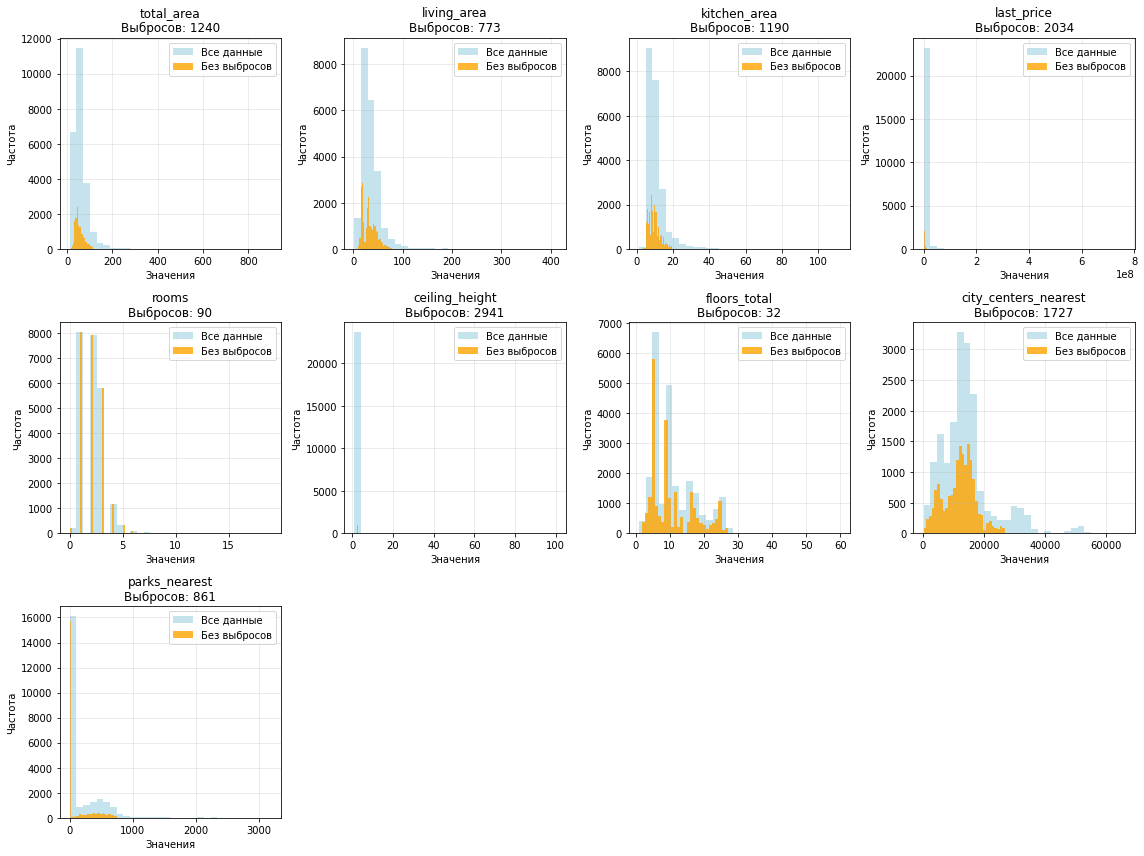

In [23]:
def plot_histograms(df, columns, normalized_data, cols_per_row=4):
    """Построение гистограмм для всех столбцов"""
    # Фильтруем только числовые столбцы, которые есть в normalized_data
    numeric_cols = [col for col in columns if col in normalized_data]
    
    if not numeric_cols:
        print("Нет числовых столбцов для построения гистограмм")
        return
    
    n_cols = len(numeric_cols)
    n_rows = (n_cols + cols_per_row - 1) // cols_per_row
    
    fig, axes = plt.subplots(n_rows, cols_per_row, figsize=(4*cols_per_row, 4*n_rows))
    axes = axes.flatten() if n_cols > 1 else [axes]
    
    for i, col in enumerate(numeric_cols):
        # Гистограмма всех данных
        axes[i].hist(df[col].dropna(), bins=30, alpha=0.7, label='Все данные', color='lightblue')
        # Гистограмма без выбросов
        axes[i].hist(normalized_data[col]['normal_data'].dropna(), bins=30, alpha=0.8, label='Без выбросов', color='orange')
        
        axes[i].set_title(f'{col}\nВыбросов: {normalized_data[col]["outliers_count"]}')
        axes[i].set_xlabel('Значения')
        axes[i].set_ylabel('Частота')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        
    # Удаляем лишние подграфики
    for i in range(n_cols, len(axes)):
        fig.delaxes(axes[i])
        
    
    plt.tight_layout()
    plt.show()
    
# Построение гистограмм
plot_histograms(df, columns_to_analyze, normalized_data)

Посмотрим на гистораммы поближе в рамках **межквартильного размаха** и выведем их только в диапазоне нормальных значений. Выведем то же самое, но без выбросов:

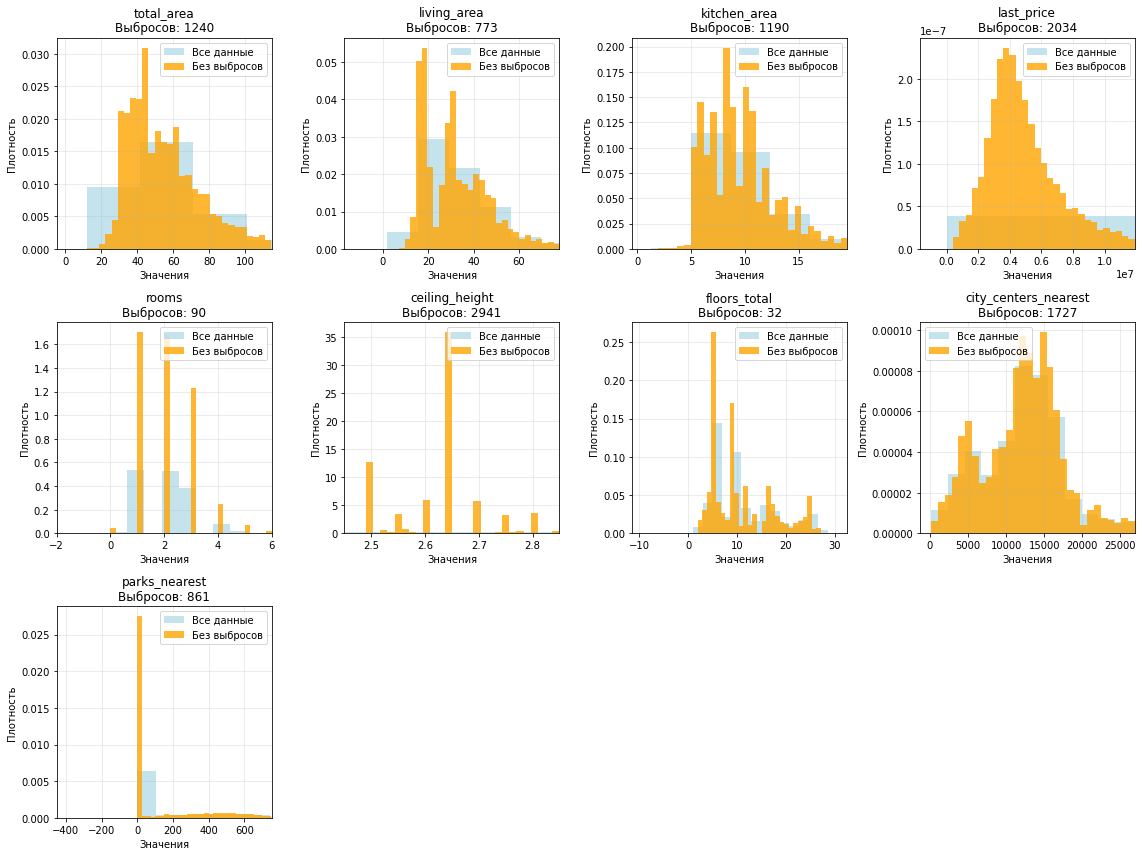

In [24]:
def plot_histograms(df, columns, normalized_data, cols_per_row=4):
    """Построение гистограмм для всех столбцов"""
    # Фильтруем только числовые столбцы, которые есть в results
    numeric_cols = [col for col in columns if col in normalized_data]
    
    if not numeric_cols:
        print("Нет числовых столбцов для построения гистограмм")
        return
    
    n_cols = len(numeric_cols)
    n_rows = (n_cols + cols_per_row - 1) // cols_per_row
    
    fig, axes = plt.subplots(n_rows, cols_per_row, figsize=(4*cols_per_row, 4*n_rows))
    axes = axes.flatten() if n_cols > 1 else [axes]
    
    for i, col in enumerate(numeric_cols):
        # Определяем диапазон для оси X
        lower_bound, upper_bound = normalized_data[col]['normal_range']
        
        # Гистограмма всех данных
        axes[i].hist(df[col].dropna(), bins=30, alpha=0.7, label='Все данные', color='lightblue', density=True)
        # Гистограмма без выбросов
        axes[i].hist(normalized_data[col]['normal_data'].dropna(), bins=30, alpha=0.8, label='Без выбросов', color='orange', density=True)
        
        # Ограничиваем ось X нормальным диапазоном
        axes[i].set_xlim(lower_bound, upper_bound)
        
        axes[i].set_title(f'{col}\nВыбросов: {normalized_data[col]["outliers_count"]}')
        axes[i].set_xlabel('Значения')
        axes[i].set_ylabel('Плотность')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    # Удаляем лишние подграфики
    for i in range(n_cols, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()
        
# Построение гистограмм
plot_histograms(df, columns_to_analyze, normalized_data)

Посмотрим в совокупности на статистическое описание нормализованного распределения данных методом .describe()

In [25]:
normal_df = pd.DataFrame({col: normalized_data[col]['normal_data'] for col in normalized_data.keys()})

# Выводим единую таблицу describe() на основе номарлизованного распределения
normal_df.describe().round(1)

,total_area,living_area,kitchen_area,last_price,rooms,ceiling_height,floors_total,city_centers_nearest,parks_nearest
count,22459.0,21023.0,20231.0,21665.0,23609.0,20758.0,23581.0,16453.0,22838.0
mean,54.4,31.6,9.5,4848768.3,2.0,2.6,10.6,12032.8,128.9
std,19.4,13.9,3.1,2229914.1,1.0,0.1,6.5,5173.2,216.6
min,12.0,2.0,1.3,12190.0,0.0,2.4,1.0,181.0,0.0
25%,39.4,18.4,7.0,3300000.0,1.0,2.6,5.0,8460.0,0.0
50%,50.1,30.0,9.0,4400000.0,2.0,2.6,9.0,12480.0,0.0
75%,65.6,41.0,11.1,6000000.0,3.0,2.6,16.0,15352.0,233.0
max,114.6,77.8,19.5,11900000.0,6.0,2.8,29.0,26872.0,751.0


Всего представлено 22459 объявений о продаже (на 1240 (5,2 %) объявлений меньше). 
Данные были номрализованы. На основе данного статистического описания мы видим как изменились данные. В скобках указаны старые значения на основе грязных данных. Приведеные цифры основываются на большинстве случаев.
* Цена: менее 1 млрд: ср.арифм = 4.8 (6.5) млн, медиана = 4.4 (4.6) млн;
* Площадь: Общая площадь до 100 м: ср. арифм = 54.4 (60.3), медиана = 50.1 (52); 
* Комнат: В среднем продаются двухкомнатные квартиры;
* Потолки: Высота потолков указана в 100 (60%) случаев и состалвяет в среднем 2.6 (2) м;
* Этажность дома: В среднем это 9-10 этажные дома;
* Жилплощадь: 30.8-31.6 (30-34) м;
* Площадь кухни: 9.4-9.5 (9.1-10.6) м;
* Близость от центра в среднем составляет 13-14 км; 
* Ближайший парк: если и есть, то в 128 (500) метрах.

Удалим ненужные строки.

In [26]:
Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df[col].notna()) & (df[col] >= lower_bound) & (df[col] <= upper_bound)]
len(df)

22838

#### Срок продажи квартиры

Изучим, как быстро продавались квартиры (столбец days_exposition). 
Посчитаем среднее и медиану.
Сколько времени обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?



In [28]:
def days_ending(n):
    """Возвращает правильное окончание для слова 'день'"""
    if 10 <= n % 100 <= 20:
        return f"{n} дней"
    elif n % 10 == 1:
        return f"{n} день"
    elif n % 10 in [2, 3, 4]:
        return f"{n} дня"
    else:
        return f"{n} дней"

days_mean = round(df['days_exposition'].mean())
days_median = round(df['days_exposition'].median())

print(f'Среднее арифметическое срока продажи квартиры {days_ending(days_mean)}.')
print(f'Медиана срока продажи квартиры {days_ending(days_median)}.')

Среднее арифметическое срока продажи квартиры 180 дней.
Медиана срока продажи квартиры 95 дней.


Построим гистограмму по срокам продажи квартиры.

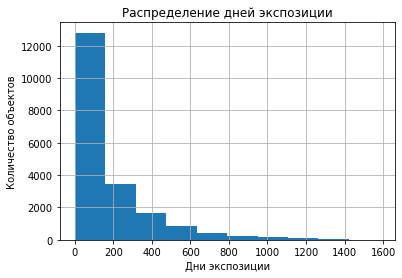

In [29]:
ax = df['days_exposition'].hist()
ax.set_title('Распределение дней экспозиции')
ax.set_xlabel('Дни экспозиции')
ax.set_ylabel('Количество объектов')
plt.show()

* Быстрыми продажами можно считать продажи, которые состоялись менее, чем за 124 дня.
* Долгими продажами можно считать продажи, срок которых больше 181 дня.
* Нормальным сроком продажи можно считать срок в рамках диапазона 124-181 день.

#### Сводные таблицы: Выявление факторов, оказывающих наибольшее влияние на цену

Для подготовки данных перед визуализацией используем сводные таблицы.


Перед визуализацией было рекомендовано создать сводные таблицы. Но что с чем группировать. Я разделил цены на 5 бинов по ценам, насколько это верно, если, например, в последний бин попало 1 объявление. Или нужно было 23.000 объявлений  разделить равномерно по 6.000 объявлений на бин? Если я разобью по объявлениям, то что я буду считать. если все-таки был не прав - сделаю бины по количеству объявлений. Поэтом сделаю сводный таблицы по пбинам по количеству объявление и вторые по бинам по цене.

In [30]:
# подготовительный бок

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

numeric_factors = ['total_area', 'living_area', 'kitchen_area', 'rooms']
    
def format_price(price):
    """Форматирование цены с апострофами для лучшей читаемости"""
    return f"{price:,.0f}".replace(',', "'")


In [31]:
def create_quantile_bins(df, column, n_bins=5):
    """Создает бины с равным количеством наблюдений в каждом"""
    return pd.qcut(df[column], q=n_bins, precision=0, duplicates='drop')

def create_summary_tables(df):
    """Создание сводных таблиц для анализа влияния факторов на цену. Квантильные бины по количеству объявлений"""
    
    print("=== СВОДНЫЕ ТАБЛИЦЫ ВЛИЯНИЯ ФАКТОРОВ НА ЦЕНУ: \n бины разделены в равной степени по количеству объявлений (наблюдений). Сам бин содержит кол-во признака (указан над бинами). ===\n")
    
    for factor in numeric_factors:
        print(f"📊 СВОДНАЯ ТАБЛИЦА: {factor.upper()}")
        df_temp = df.copy()
        df_temp[f'{factor}_bins'] = create_quantile_bins(df, factor, 5)
        
        summary = df_temp.groupby(f'{factor}_bins')['last_price'].agg([
            ('Количество', 'count'),
            ('Средняя цена', 'mean'),
            ('Медиана', 'median'),
            ('Мин цена', 'min'),
            ('Макс цена', 'max'),
            ('Станд. откл.', 'std')
        ]).round(0)
        
        # Добавляем процент от общего количества
        summary['Доля %'] = (summary['Количество'] / len(df) * 100).round(1)
        
        # Форматируем цены с апострофами
        summary_formatted = summary.copy()
        price_columns = ['Средняя цена', 'Медиана', 'Мин цена', 'Макс цена', 'Станд. откл.']
        for col in price_columns:
            summary_formatted[col] = summary[col].apply(format_price)
        
        # Отображаем как DataFrame без переносов
        print(summary_formatted.to_string())
        print(f"Разброс средних цен: {format_price(summary['Средняя цена'].max() - summary['Средняя цена'].min())}")
        print("-" * 120)
        print()
    
create_summary_tables(df)

=== СВОДНЫЕ ТАБЛИЦЫ ВЛИЯНИЯ ФАКТОРОВ НА ЦЕНУ: 
 бины разделены в равной степени по количеству объявлений (наблюдений). Сам бин содержит кол-во признака (указан над бинами). ===

📊 СВОДНАЯ ТАБЛИЦА: TOTAL_AREA
                 Количество Средняя цена     Медиана Мин цена    Макс цена Станд. откл.  Доля %
total_area_bins                                                                                
(12.0, 37.0]           4571    3'131'617   3'150'000  430'000   28'000'000    1'143'922    20.0
(37.0, 46.0]           4825    3'887'527   3'900'000  440'000   24'412'900    1'334'342    21.1
(46.0, 58.0]           4449    4'675'969   4'700'000  430'000   39'900'000    1'758'897    19.5
(58.0, 74.0]           4433    6'053'917   5'800'000  730'000   40'000'000    2'534'942    19.4
(74.0, 900.0]          4560   14'796'549  10'000'000  850'000  763'000'000   22'416'842    20.0
Разброс средних цен: 11'664'932
----------------------------------------------------------------------------------------

Если делить объявления в равной степени для свободной таблицы, то мы видим, что наибольший размах цен по признаку **количеству комнат**, на основании чего следует сделать вывод, что количество комнат является наиболее влиятельным фактором. Однако в то же время можно заметить, что с возрастанием количества комнат коэффицент корреляции средней цены теряет силу взаимосвязи: средняя цена увеличивается не так сильно.

In [32]:
def create_bins(df, column, n_bins=5):
    """Создание бинов для числовых столбцов с понятными названиями диапазонов. Бины по признаку"""
    bins = pd.cut(df[column], bins=n_bins)
    # Создаем понятные названия с диапазонами
    labels = []
    for interval in bins.cat.categories:
        left = round(interval.left, 1)
        right = round(interval.right, 1)
        labels.append(f'{left}-{right}')
    
    return pd.cut(df[column], bins=n_bins, labels=labels)

def create_summary_tables(df):
    """Создание сводных таблиц для анализа влияния факторов на цену"""
    
    print("=== СВОДНЫЕ ТАБЛИЦЫ ВЛИЯНИЯ ФАКТОРОВ НА ЦЕНУ: бины по признаку ===\n")
    
    for factor in numeric_factors:
        print(f"📊 СВОДНАЯ ТАБЛИЦА: {factor.upper()}")
        df_temp = df.copy()
        df_temp[f'{factor}_bins'] = create_bins(df, factor, 5)
        
        summary = df_temp.groupby(f'{factor}_bins')['last_price'].agg([
            ('Количество', 'count'),
            ('Средняя цена', 'mean'),
            ('Медиана', 'median'),
            ('Мин цена', 'min'),
            ('Макс цена', 'max'),
            ('Станд. откл.', 'std')
        ]).round(0)
        
        # Добавляем процент от общего количества
        summary['Доля %'] = (summary['Количество'] / len(df) * 100).round(1)
        
        # Форматируем цены с апострофами
        summary_formatted = summary.copy()
        price_columns = ['Средняя цена', 'Медиана', 'Мин цена', 'Макс цена', 'Станд. откл.']
        for col in price_columns:
            summary_formatted[col] = summary[col].apply(format_price)
        
        # Отображаем как DataFrame без переносов
        print(summary_formatted.to_string())
        print(f"Разброс средних цен: {format_price(summary['Средняя цена'].max() - summary['Средняя цена'].min())}")
        print("-" * 120)
        print()
    
    # 2. Сводная таблица для категориальных факторов
    categorical_factors = ['floor_type', 'publication_day_of_week', 'publication_month', 'publication_year']
    
    for factor in categorical_factors:
        if factor in df.columns:
            print(f"📊 СВОДНАЯ ТАБЛИЦА: {factor.upper()}")
            
            summary = df.groupby(factor)['last_price'].agg([
                ('Количество', 'count'),
                ('Средняя цена', 'mean'),
                ('Медиана', 'median'),
                ('Мин цена', 'min'),
                ('Макс цена', 'max'),
                ('Станд. откл.', 'std')
            ]).round(0)
            
            # Добавляем процент от общего количества
            summary['Доля %'] = (summary['Количество'] / len(df) * 100).round(1)
            
            # Сортируем по средней цене
            summary = summary.sort_values('Средняя цена', ascending=False)
            
            # Форматируем цены с апострофами
            summary_formatted = summary.copy()
            price_columns = ['Средняя цена', 'Медиана', 'Мин цена', 'Макс цена', 'Станд. откл.']
            for col in price_columns:
                summary_formatted[col] = summary[col].apply(format_price)
            
            # Отображаем как DataFrame без переносов
            print(summary_formatted.to_string())
            print(f"Разброс средних цен: {format_price(summary['Средняя цена'].max() - summary['Средняя цена'].min())}")
            print("-" * 120)
            print()
    
    # 3. Общая сводка влияния факторов
    print("📈 ОБЩАЯ СВОДКА ВЛИЯНИЯ ФАКТОРОВ")
    print("=" * 50)
    
    factor_impact = []
    
    # Анализ числовых факторов
    for factor in numeric_factors:
        df_temp = df.copy()
        df_temp[f'{factor}_bins'] = create_bins(df, factor, 5)
        price_range = df_temp.groupby(f'{factor}_bins')['last_price'].mean()
        impact = price_range.max() - price_range.min()
        factor_impact.append((factor, impact, 'числовой'))
    
    # Анализ категориальных факторов
    for factor in categorical_factors:
        if factor in df.columns:
            price_range = df.groupby(factor)['last_price'].mean()
            impact = price_range.max() - price_range.min()
            factor_impact.append((factor, impact, 'категориальный'))
    
    # Сортируем по силе влияния
    factor_impact.sort(key=lambda x: x[1], reverse=True)
    
    print("Ранжирование факторов по силе влияния на цену. Указана разница цены между наименьшей и наибольшей в рамках одного фактора." 
          "Отображается наибольшая разница в цене по каждому фактору, что означает наибольшее влияние данного фактора на диапазон изменения цены"
          "(наибольший размах - наибольшее влияние).")
    for i, (factor, impact, ftype) in enumerate(factor_impact, 1):
        print(f"{i}. {factor}: {format_price(impact)} руб. ({ftype})")
    
    print("\n" + "=" * 80 + "\n")
    
create_summary_tables(df)

=== СВОДНЫЕ ТАБЛИЦЫ ВЛИЯНИЯ ФАКТОРОВ НА ЦЕНУ: бины по признаку ===

📊 СВОДНАЯ ТАБЛИЦА: TOTAL_AREA
                 Количество Средняя цена      Медиана     Мин цена    Макс цена Станд. откл.  Доля %
total_area_bins                                                                                     
12.1-190.4            22594    5'947'450    4'590'000      430'000  330'000'000    6'214'187    98.9
190.4-367.8             214   45'276'143   29'700'000    7'900'000  245'000'000   39'177'755     0.9
367.8-545.2              26  119'954'547   63'900'000   27'000'000  763'000'000  155'773'803     0.1
545.2-722.6               3  193'333'333  140'000'000  140'000'000  300'000'000   92'376'043     0.0
722.6-900.0               1  420'000'000  420'000'000  420'000'000  420'000'000          nan     0.0
Разброс средних цен: 414'052'550
------------------------------------------------------------------------------------------------------------------------

📊 СВОДНАЯ ТАБЛИЦА: LIVING_AREA
         

На основе сводных таблиц мы можем определить степень влияния различных факторов на ценообразование.
* ***Наибольшее влияние***
* **Общая площадь:** Наибольший средний разброс обычно указывает на наибольшее влияние фактора. Наибольший средний размах цены выявлен по фактору общей площади. Что,  вероятно, говорит о том, что по данному фактору выявлена наибольшая разница в цене между минимальной и максимальной 414'052'550 руб. Однако, скорее всего, прямая линейная корреляция со стоимостью квадратного метра. Больше всего продается квартир с площадью в диапазоне 12-190 м по средней цене 4.6-6.2 млн. Таких объявлений 99 %. Стандартное отклонение 6.2 млн на наибольшем объеме данных (99 %) в первом бине - минимальное среди остальных факторов. Это говорит о том, разброс значений минимальный и менее вариантивный при едином количестве метража, а значит, на наш взгляд, непосредственное **наиболее сильное влияение на цену имеет именно метраж**.
    
  
* ***Наименьшее влияние***.
* **Дата публикации:** оказывает наименьшее значение, а именно **день и месяц публикации оказывает наименьшее влияние** на срок продажи квартиры, однако, месяц пуликации объявления оказывает чуть большее влияние. Для уточнения данного вопроса возможно рассмотреть конкретные месяцы, а также условия ипотечного кредитования в данный период времени. Более заметное влияние на цену оказывает год публикации, он составляет 6'365'967. Что вероятно говорит о том, что рыночные условия меняются от года к году. Однако в целом, дата публикации в половине наименне влиящих факторов.

#### Корреляционный анализ по числовым факторам

Построим графики, которые покажут зависимость цены от указанных выше параметров. 

Определим  факторы, которые больше всего влияют на общую (полную) стоимость объекта.
Изучим, зависит ли цена от:
общей площади;
жилой площади;
площади кухни;
количества комнат;
этажа, на котором расположена квартира (первый, последний, другой);
даты размещения (день недели, месяц, год).


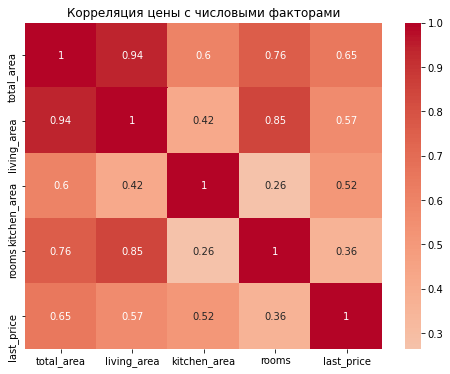

Корреляция с ценой (по убыванию силы связи):
  total_area: 0.654 (умеренная)
  living_area: 0.567 (умеренная)
  kitchen_area: 0.516 (умеренная)
  rooms: 0.361 (умеренная)

Наиболее влияющий фактор: total_area (0.654)



In [33]:
def analyze_price_correlation(df):
    """Анализ корреляции цены с другими факторами"""
    # Числовые столбцы для корреляции
    numeric_cols = ['total_area', 'living_area', 'kitchen_area', 'rooms', 'last_price']
    
    # Корреляционная матрица
    corr_matrix = df[numeric_cols].corr()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Корреляция цены с числовыми факторами')
    plt.show()
    
    # Коэффициенты корреляции с ценой
    price_corr = corr_matrix['last_price'].drop('last_price')
    
    # Сортировка по абсолютному значению корреляции
    price_corr_sorted = price_corr.reindex(price_corr.abs().sort_values(ascending=False).index)
    
    print("Корреляция с ценой (по убыванию силы связи):")
    for col, corr in price_corr_sorted.items():
        strength = "сильная" if abs(corr) > 0.7 else "умеренная" if abs(corr) > 0.3 else "слабая"
        print(f"  {col}: {corr:.3f} ({strength})")
    
    print(f"\nНаиболее влияющий фактор: {price_corr_sorted.index[0]} ({price_corr_sorted.iloc[0]:.3f})")
    print()
    
analyze_price_correlation(df)

При определении корреляции среди четырех числовых факторов выявленно условно умеренное влияние на цену, однако среди них **наибольшую степень влияния оказывает общая площадь.**

#### Анализ по категориальным факторам

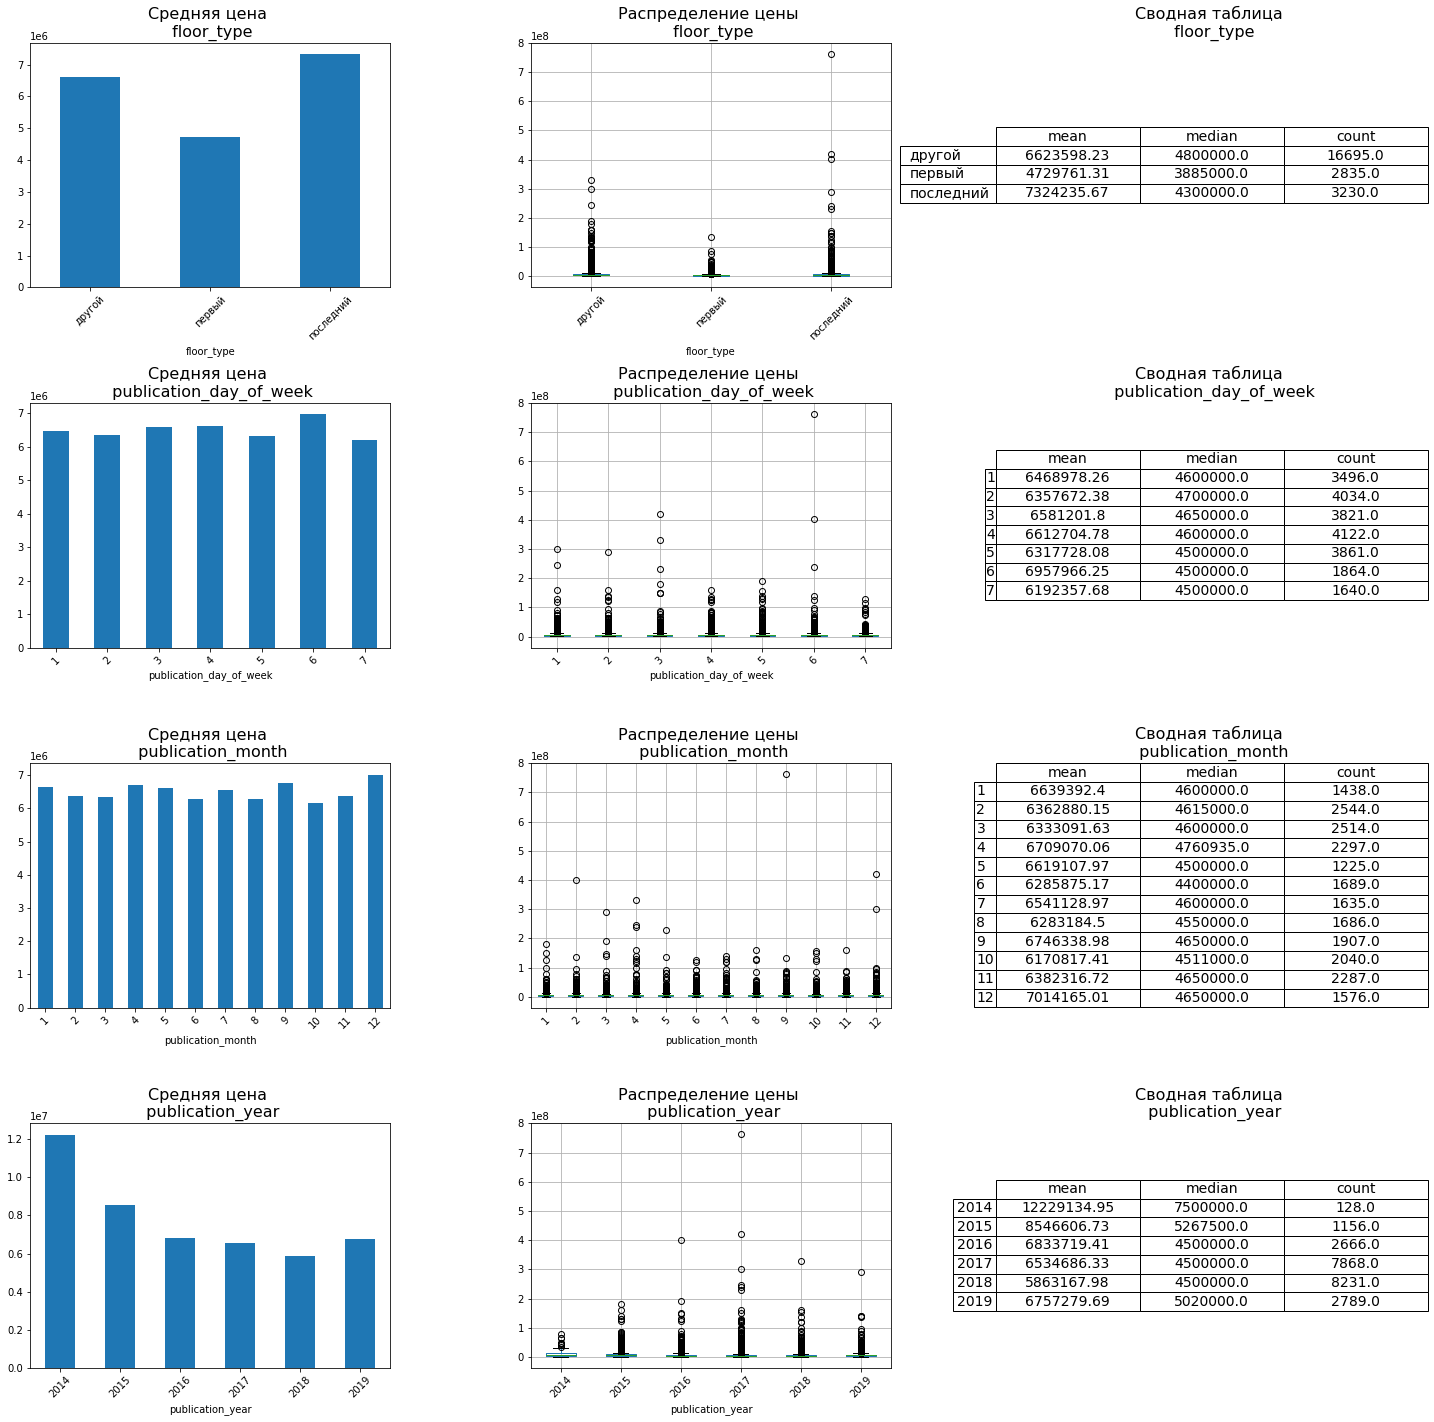

In [34]:
categorical_factors = ['floor_type', 'publication_day_of_week', 'publication_month', 'publication_year']
valid_factors = [f for f in categorical_factors if f in df.columns]

fig, axes = plt.subplots(len(valid_factors), 3, figsize=(20, 5 * len(valid_factors)))
if len(valid_factors) == 1:
    axes = [axes]

for i, factor in enumerate(valid_factors):
    price_by_cat = df.groupby(factor)['last_price'].agg(['mean', 'median', 'count'])

    # Средняя цена
    price_by_cat['mean'].plot(kind='bar', ax=axes[i][0])
    axes[i][0].set_title(f'Средняя цена \n {factor}', fontsize=16)
    axes[i][0].tick_params(axis='x', rotation=45)

    # Boxplot
    df.boxplot(column='last_price', by=factor, ax=axes[i][1])
    axes[i][1].set_title(f'Распределение цены \n {factor}', fontsize=16)
    axes[i][1].tick_params(axis='x', rotation=45)
    plt.suptitle('')
    
    # Таблица статистик
    axes[i][2].axis('tight')
    axes[i][2].axis('off')
    table = axes[i][2].table(cellText=price_by_cat.round(2).values, 
                            rowLabels=price_by_cat.index,
                            colLabels=price_by_cat.columns,
                            cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.scale(1.2, 1.5)
    axes[i][2].set_title(f'Сводная таблица \n {factor}', fontsize=16)

plt.tight_layout()
plt.show()

При визуализации средней цены по различным факторам, мы определили как влияют различные факторына цену:
* **Тип этажа**: первый этаж дешевле всего, средний этаж дороже всего, и цены на него могут сильно варьироваться (за счет оставшихся выбросов в рамках межквартильного размаха);
* **День публикации**: меньше всего влияет на успешность продажи квартиры, хотя чуть больше можно получить успеха при продаже квартиры, если выставить на продажу квартиру в субботу.
* **Месяц публикации**: В целом, месяц публикации не имеет особого влияния на ценообразование. Но в то же время **самыми неудачными месяцами для публикации объявляений мы считаем летние месяцы**. Вероятные причины: люди заранее смотрят объявления о покупке недвижимости, сравнивают, думают. Если дети готовятся к поступлению в другом городе, то заранее до летних месяцев люди уже присматривают варианты и т.д. Кроме того, летом сезон отпусков, и многие совмещают с отпусков свои увольнения, переходы на другую работу, свадьбы или переезд в другой город, это планируется заранее. Именно по этой причине наиболее удачными  месяцами мы находим весенние месяцы и декабрь (многие, вероятно, получили 13-ю зарплату, успеть до новогоднего повышения цен, предновогодняя стимуляция продаж).
* **Средняя цена**: Наибольшая средняя цена продажи квартиры была в 2014 году, затем постепенно средняя цена снижалась.


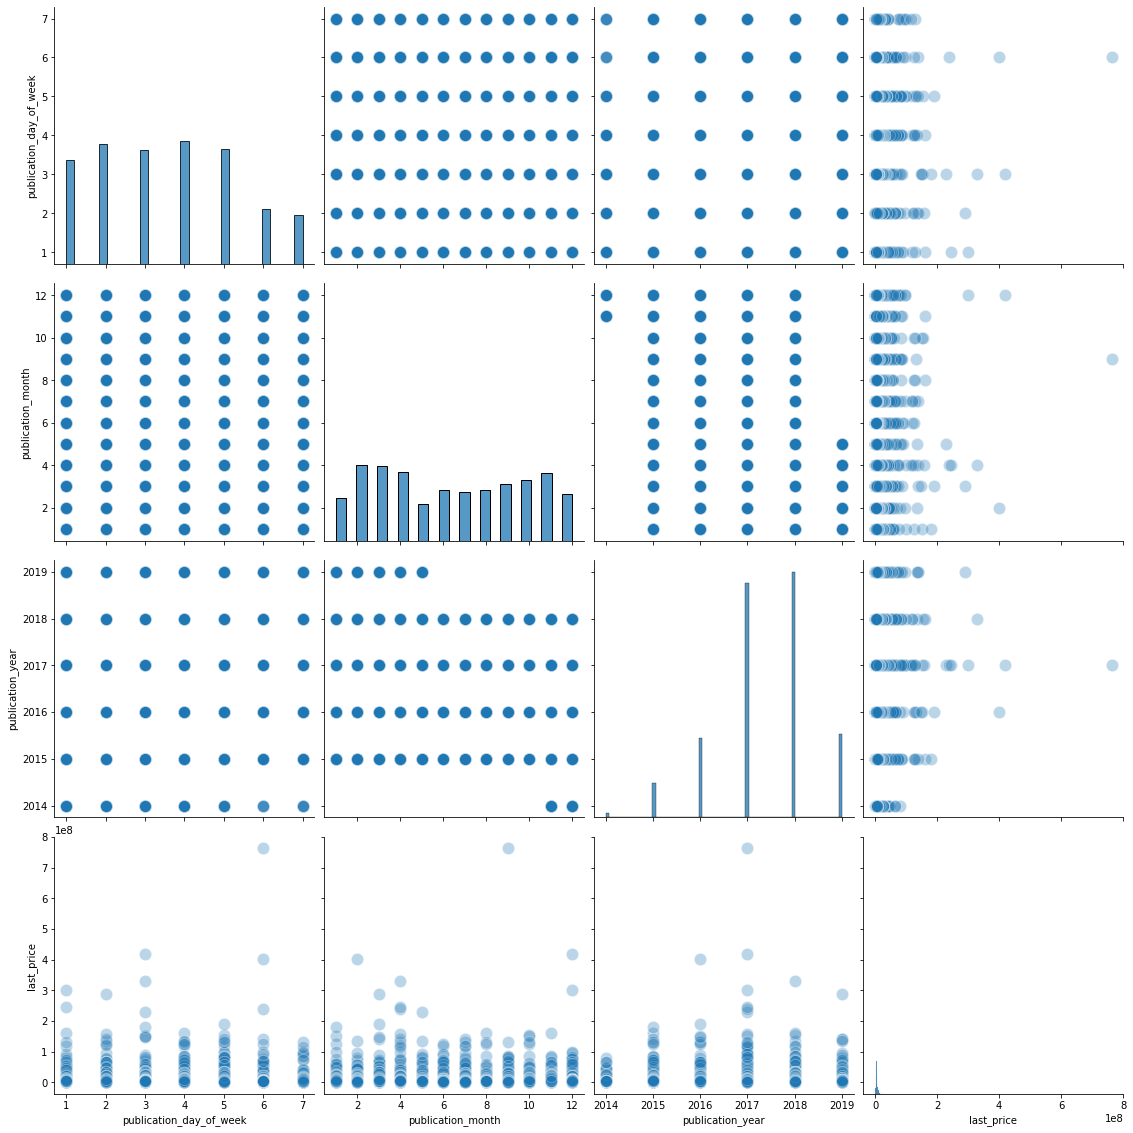

In [35]:
# df = df[['floor_type', 'publication_day_of_week', 'publication_month', 'publication_year', 'last_price']]
sns.pairplot(df, vars=['publication_day_of_week', 'publication_month', 'publication_year', 'last_price'], 
             height=4, plot_kws={'alpha': 0.3, 's': 150})
plt.show()

#### Топ-10 населенных пунктов по количеству объявлений

Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений — построим сводную таблицу с количеством объявлений и средней ценой квадратного метра для этих населенных пунктов. Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра.


In [36]:
# Топ-10 населенных пунктов по количеству объявлений
top_localities = df['locality_name'].value_counts().head(10).index

# Фильтруем данные по топ-10 населенным пунктам
df_top = df[df['locality_name'].isin(top_localities)]

# Сводная таблица с количеством объявлений и средней ценой за м²
summary_table = df_top.groupby('locality_name').agg({
    'price_1m': 'mean',
    'locality_name': 'count'
}).rename(columns={'locality_name': 'кол-во', 'price_1m': 'средняя цена руб/м²'}).round(2)

# Сортируем по средней цене за м²
summary_table = summary_table.sort_values('средняя цена руб/м²', ascending=False)

print("Топ-10 населенных пунктов по количеству объявлений:")
print(summary_table)

print(f"\nСамая высокая стоимость м²: {summary_table.index[0]} - {summary_table.iloc[0]['средняя цена руб/м²']} руб/м²")
print(f"Самая низкая стоимость м²: {summary_table.index[-1]} - {summary_table.iloc[-1]['средняя цена руб/м²']} руб/м²")


Топ-10 населенных пунктов по количеству объявлений:
                 средняя цена руб/м²  кол-во
locality_name                               
Санкт-Петербург            114576.33   14910
Пушкин                     103058.89     363
Кудрово                     95324.96     472
Парголово                   90205.88     326
Мурино                      86087.51     590
Шушары                      78677.38     440
Колпино                     75333.10     322
Гатчина                     68746.11     307
Всеволожск                  68654.47     398
Выборг                      58141.92     237

Самая высокая стоимость м²: Санкт-Петербург - 114576.33 руб/м²
Самая низкая стоимость м²: Выборг - 58141.92 руб/м²


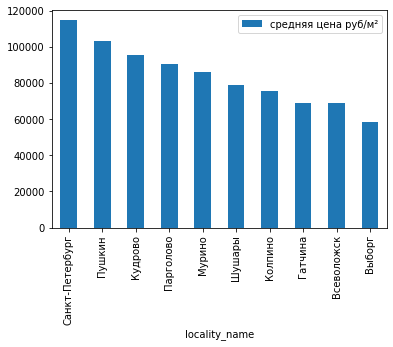

In [37]:
summary_table.reset_index().plot(kind='bar', x='locality_name', y='средняя цена руб/м²')
plt.show()

#### Влияние удаленности от центра на цену

Ранее мы посчитали расстояние до центра в километрах. Теперь выделим квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислим их среднюю стоимость на разном удалении от центра. Учтем каждый километр расстояния: узнаем среднюю цену квартир в одном километре от центра, в двух и так далее. Опишем, как стоимость объектов зависит от расстояния до центра города — построим график изменения средней цены для каждого километра от центра Петербурга.


Цены по удаленности от центра (Санкт-Петербург):
                    mean      median  count
distance_km                                
0            31449115.85  17900000.0     27
1            21885901.12  11395000.0    178
2            17845371.60  10000000.0    307
3            10873123.81   8375000.0    334
4            13613437.50   9250000.0    668
5            14492643.62   9500000.0    856
6            15545597.83   8721680.0    565
7            14918554.97   7800000.0    409
8             9903332.48   7200000.0    569
9             6776642.62   5207500.0    538
10            6505562.49   5050000.0    679
11            6041841.74   4999000.0   1091
12            5853490.88   4950000.0   1559
13            6091340.03   5200000.0   1325
14            5666924.92   4900000.0   1253
15            5845534.09   4900000.0   1472
16            5375660.58   4800000.0   1228
17            5154703.96   4550000.0    827
18            5036674.08   4300000.0    244
19            5043603.67  

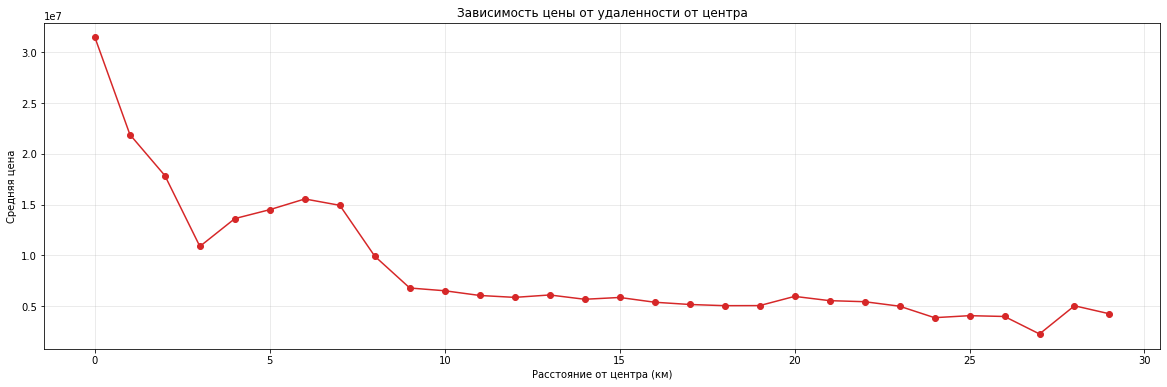

In [38]:
# Анализ цен по удаленности от центра для Санкт-Петербурга
spb_data = df[df['locality_name'] == 'Санкт-Петербург'].copy()
spb_data = spb_data.dropna(subset=['city_centers_nearest_km'])  # Удаляем NaN
spb_data['distance_km'] = spb_data['city_centers_nearest_km'].round().astype(int)

price_by_distance = spb_data.groupby('distance_km')['last_price'].agg(['mean', 'median', 'count']).round(2)
price_by_distance = price_by_distance.sort_index()  # Сортировка по distance_km
print("\nЦены по удаленности от центра (Санкт-Петербург):")
print(price_by_distance)

plt.figure(figsize=(20, 6))
plt.plot(price_by_distance.index, price_by_distance['mean'], color='tab:red', marker='o')
plt.xlabel('Расстояние от центра (км)')
plt.ylabel('Средняя цена')
plt.title('Зависимость цены от удаленности от центра')
plt.grid(True, alpha=0.3)
plt.show()

fig.tight_layout()
plt.show()

Мы определили **наибольшее влияние близости объекта недвижимости к центру на ценообразование**: чем ближе объект к центру, ты выше средняя цена. При близости объекта к центру возникает экспоненциальное ускорению, и наоброт, при удалении от центра - экспоненциальное замедление.

### Общий вывод

**Наибольшее влияние**. Мы определили **два наиболее влиятельных фактора**, оказывающих наиболее заметное влияние на ценообразование. На наш взгляд, это:
* **Общая площадь объекта недвижимости**:  размах цены 414 млн руб; коэффициент корреляции у него также самый высокий 0.654
* **Удаленность от центра**: Чем ближе к центру, тем сильнее цена увеличивается экспоненциально. В то же время наибольшее число объектов продается именно в основной части  Санкт-Петербурга (14910), а не в удаленных районнах города (если рассматривать его как регион) и не в пригородах. Среднняя цена квадратного метра в СПб 114 т.р./м², в удаленных районнах цена падает в разы.

**Среднее умеренное влияние**:
Примерно в равной степени умеренно влияют такие параметры как **жилая площадь, кухня, количество комнат, этаж**. Так хуже оцениваются первый и последний этаж, **предпочитают брать квартиры посередине** (тип этажа "другой"). 


**Наименее заметное влияние** оказывает **дата публикации**, однако стоит отметить, что хуже всего продаются квартиры выставленные в летние месяцы, а в 2014 году средня цена продажи квартиры была выше, а затем средняя цена со временем снижалась (хотя это странно, снизилась покупательская способность населения из-за санкций и из-аз различных небезызвестных событий?)

**Срок проодажи** 
* Быстрые продажи: раньше, чем за 124 дня.
* Долгие продажи: дольше 181 дня.
* Нормальные продажи: срок в рамках диапазона 124-181 день.

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Файл с данными открыт.
- [х]  Файл с данными изучен: выведены первые строки, использован метод `info()`, построены гистограммы.
- [х]  Найдены пропущенные значения.
- [х]  Пропущенные значения заполнены там, где это возможно.
- [х]  Объяснено, какие пропущенные значения обнаружены.
- [х]  В каждом столбце установлен корректный тип данных.
- [х]  Объяснено, в каких столбцах изменён тип данных и почему.
- [х]  Устранены неявные дубликаты в названиях населённых пунктов.
- [х]  Обработаны редкие и выбивающиеся значения (аномалии).
- [х]  В таблицу добавлены новые параметры:
       – цена одного квадратного метра;
       – день публикации объявления (0 - понедельник, 1 - вторник и т. д.);
       – месяц публикации объявления;
       – год публикации объявления;
       – тип этажа квартиры (значения — «первый», «последний», «другой»);
       – расстояние до центра города в километрах.
- [х]  Изучены и описаны параметры: (дважды методом .describe() и в начале и в середине работы)
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего парка.
- [х]  Выполнено задание «Изучите, как быстро продавались квартиры (столбец `days_exposition`)»:
    - построена гистограмма;
    - рассчитаны среднее и медиана;
    - описано, сколько обычно занимает продажа и указано, какие продажи можно считать быстрыми, а какие — необычно долгими.
- [х]  Выполнено задание «Определите факторы, которые больше всего влияют на общую (полную) стоимость объекта». Построены графики, которые показывают зависимость цены от параметров: **!!! ХУЖЕ ВСЕГО ЭТО ПОНЯЛ КАК ЭТО СТРОИТЬ И КАК ЭТО ИНТЕРПРЕТИРОВАТЬ**
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - количество комнат;
        - тип этажа, на котором расположена квартира (первый, последний, другой);
        - дата размещения (день недели, месяц, год).
- [х]  Выполнено задание «Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений»:
    - выделены населённые пункты с самой высокой и низкой стоимостью квадратного метра.
- [х]  Выполнено задание «Выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите их среднюю стоимость на разном удалении от центра»:
    -  учтён каждый километр расстояния, известны средние цены квартир в одном километре от центра, в двух и так далее;
    -  описано, как стоимость объекта зависит от расстояния до центра города;
    -  построен график изменения средней цены для каждого километра от центра Петербурга.
- [х]  На каждом этапе сделаны промежуточные выводы.
- [х]  В конце проекта сделан общий вывод.

<div class="alert alert-success">
<b>✔️ Итоговый комментарий ревьюера v2:</b>
<br>Все правки выполнены. Молодец!
<br>Я рад был поработать над проверкой твоей работы) В качестве дополнительного материала для изучения могу порекомендовать следующий ресурс:

	https://www.python-graph-gallery.com/
<br>В нем содержится большая библиотека графиков с готовым кодом, который можно использовать при работе.
<br>Поздравляю со сдачей проекта и желаю удачи в дальнейшем обучении! 😉    
</div>